In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
source_dir = './oxford_pets/images'  # Path to extracted images
target_dir = './oxford_pets_filtered'  # New folder for 5-class dataset
classes = ['Abyssinian', 'Bengal', 'Beagle', 'Boxer', 'Pug']  # Selected breeds

# Create train and validation directories
train_dir = os.path.join(target_dir, 'train')
val_dir = os.path.join(target_dir, 'validation')
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Get list of images for selected classes
image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg') and any(cls in f for cls in classes)]

# Split into train (80%) and validation (20%)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Copy files to respective directories
for f in train_files:
    cls = next(c for c in classes if c in f)
    shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, cls, f))
for f in val_files:
    cls = next(c for c in classes if c in f)
    shutil.copy(os.path.join(source_dir, f), os.path.join(val_dir, cls, f))

print(f"Created dataset with {len(train_files)} training and {len(val_files)} validation images.")

Created dataset with 320 training and 80 validation images.


In [8]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Define paths
import os
base_dir = './oxford_pets_filtered'  # Path to the filtered 5-class dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Set image size and batch size
IMG_SIZE = 224  # MobileNetV2 expects 224x224
BATCH_SIZE = 32

In [5]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Changed for multi-class
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Changed for multi-class
)

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [7]:
# Load MobileNetV2 without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers
base_model.trainable = False

I0000 00:00:1748389222.448540  173533 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Changed to 5 units for 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Changed loss

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

/home/stephen/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1748389246.380022  173682 service.cc:152] XLA service 0x7f083c00f270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748389246.380063  173682 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-28 05:10:46.464962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748389247.069742  173682 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-28 05:10:48.145761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4391', 204 bytes spill stores, 204 bytes spill loads

2025-05-28 05:10:48.147811: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:41 11s/step - accuracy: 0.2812 - loss: 2.5731

I0000 00:00:1748389255.345693  173682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4956 - loss: 1.3482

2025-05-28 05:11:00.647423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 116 bytes spill stores, 116 bytes spill loads

2025-05-28 05:11:00.832347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 200 bytes spill stores, 536 bytes spill loads

2025-05-28 05:11:01.069249: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 4 bytes spill stores, 4 bytes spill loads

2025-05-28 05:11:01.454709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5340 bytes spill stores, 5324 bytes spill loads

2025-05-28 05:11:01.559578: I ex

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5065 - loss: 1.3049 - val_accuracy: 0.8125 - val_loss: 0.4092
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.8245 - loss: 0.4228 - val_accuracy: 0.8875 - val_loss: 0.2474
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.9187 - loss: 0.2068 - val_accuracy: 0.8500 - val_loss: 0.3346
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.9392 - loss: 0.1905 - val_accuracy: 0.9125 - val_loss: 0.1946
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.9381 - loss: 0.1886 - val_accuracy: 0.8875 - val_loss: 0.2382


In [11]:
# Unfreeze the top 10 layers
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8693 - loss: 0.8090 - val_accuracy: 0.8750 - val_loss: 0.7202
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.9481 - loss: 0.3664 - val_accuracy: 0.8500 - val_loss: 0.9552
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.9387 - loss: 0.1608 - val_accuracy: 0.8375 - val_loss: 1.2186
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.9345 - loss: 0.1152 - val_accuracy: 0.8500 - val_loss: 1.2141
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.9525 - loss: 0.1039 - val_accuracy: 0.8625 - val_loss: 1.1504


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8609 - loss: 1.1494
Validation Accuracy: 0.8625


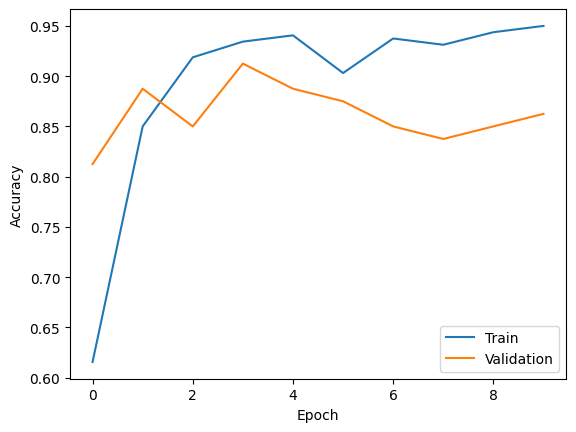

In [12]:
# Evaluate
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
base_dir = './oxford_pets_filtered'  # Path to the filtered 5-class dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load class names
class_names = list(train_generator.class_indices.keys())  # ['Abyssinian', 'Bengal', 'Beagle', 'Boxer', 'Pug']

# Load and preprocess a test image
img_path = os.path.join(validation_dir, 'Abyssinian/Abyssinian_44.jpg')  # Adjust path as needed
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction[0])]
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Abyssinian
